<a href="https://colab.research.google.com/github/Amrutha369/voice-spoofing-detection/blob/main/voice_spoofing_detection_using_cnn_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikeras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!pip install tensorflow-io
import os
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt #plotting library
import numpy as np #numerical computing
import tensorflow as tf
import seaborn as sns # statistical data visualization
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.1 MB/s eta 0:00:00


In [4]:
# Audio params
SAMPLE_RATE = 16000 #The number of samples of audio carried per second, measured in Hertz (Hz).

# Spectrogram params
N_MELS = 128 # freq axis
SPEC_WIDTH = 256 #

# CNN params
NUM_CLASSES = 2 # bonafide or spoof
BATCH_SIZE = 16 # The number of samples processed in each training batch
EPOCHS = 100 # the number of times the entire dataset is passed forward and backward through the neural network during training.
LEARNING_RATE = 0.0001 # adjust based on your model peArformance


In [5]:
# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
val_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
test_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [6]:
# Function to form the full path of a file
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [7]:
# Function to read the dataset
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Function to convert class_name to integer
def label_to_int(class_name):
    if class_name == 'real':
        return 0
    else:
        return 1

# Add target column and subset to DataFrame
def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

# Take samples from each DataFrame
def sample_data(df, n_real, n_fake):
    real = df[df['class_name'] == 'real'].head(n_real)
    fake = df[df['class_name'] != 'real'].head(n_fake)
    return pd.concat([real, fake])

In [8]:
# Create DataFrames for each dataset
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
val_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), val_dir)
test_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), test_dir)

# Add columns to each DataFrame
train_df = add_columns(train_df, 'train')
val_df = add_columns(val_df, 'val')
test_df = add_columns(test_df, 'test')

# Take samples from each DataFrame by a different number
train_df = sample_data(train_df, 175, 525)
val_df = sample_data(val_df, 37, 113)
test_df = sample_data(test_df, 37, 113)

In [10]:
#Combine three dataframes into one dataframe
data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [11]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0089,LA_T_1000406,-,real,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
1,LA_0088,LA_T_1007571,-,real,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
2,LA_0090,LA_T_1007663,-,real,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
3,LA_0084,LA_T_1011221,-,real,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
4,LA_0086,LA_T_1013597,-,real,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
...,...,...,...,...,...,...,...
995,PA_0084,PA_T_0005514,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,test
996,PA_0084,PA_T_0005515,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,test
997,PA_0084,PA_T_0005516,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,test
998,PA_0084,PA_T_0005517,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,test


In [12]:
import librosa

def audio_to_spectrogram(filepath):
    # Load audio file using librosa
    audio, sample_rate = librosa.load(filepath)

    # Normalize the audio
    audio_norm = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
    # A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.
    # Compute the spectrogram using librosa
    spectrogram = librosa.feature.melspectrogram(y=audio_norm, sr=sample_rate)

    # Convert the spectrogram to decibels
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Add channel dimension
    spectrogram_db = np.expand_dims(spectrogram_db, axis=-1)

    # Resize spectrogram to the specified size
    image = tf.image.resize(spectrogram_db, [SPEC_WIDTH, N_MELS])

    return image

# Adding the spectrogram column to the DataFrame
data_df['spectrogram'] = data_df['filepath'].apply(audio_to_spectrogram)


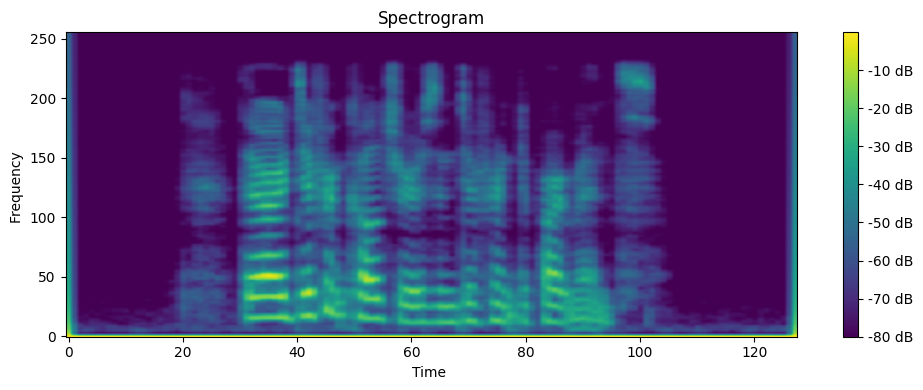

The size of the spectrogram is: (256, 128, 1)


In [13]:
# Selecting a spectrogram from the DataFrame
first_spectrogram = data_df.loc[1, 'spectrogram']

# Using the imshow function to display the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(tf.squeeze(first_spectrogram), aspect='auto', origin='lower', cmap='viridis')
plt.title('Spectrogram')
plt.ylabel('Frequency ')
plt.xlabel('Time ')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
print("The size of the spectrogram is:", first_spectrogram.shape)

In [14]:
# Splitting the data based on the 'subset' column
train_data = data_df[data_df['subset'] == 'train']
val_data = data_df[data_df['subset'] == 'val']
test_data = data_df[data_df['subset'] == 'test']

# Converting the list of spectrograms into NumPy arrays
X_train = np.stack(train_data['spectrogram'].to_list())
X_val = np.stack(val_data['spectrogram'].to_list())
X_test = np.stack(test_data['spectrogram'].to_list())

# Converting target into NumPy arrays
y_train = train_data['target'].to_numpy()
y_val = val_data['target'].to_numpy()
y_test = test_data['target'].to_numpy()

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")#Contains target labels
print(f"X_dev shape: {X_val.shape}")
print(f"y_dev shape: {y_val.shape}")
print(f"X_eval shape: {X_test.shape}")
print(f"y_eval shape: {y_test.shape}")

X_train shape: (700, 256, 128, 1)
y_train shape: (700,)
X_dev shape: (150, 256, 128, 1)
y_dev shape: (150,)
X_eval shape: (150, 256, 128, 1)
y_eval shape: (150,)


In [16]:
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 4th conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Additional dense layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the CNN model with Adam optimizer
cnn_model = create_cnn_model((X_train.shape[1], X_train.shape[2], 1))


In [ ]:
# Display the summary of the CNN model
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 63, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 63, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 61, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 31, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16)


Epoch 1/50
44/44 [==============================] - 35s 720ms/step - loss: 0.6236 - accuracy: 0.6829
Epoch 2/50
44/44 [==============================] - 32s 732ms/step - loss: 0.4763 - accuracy: 0.7700
Epoch 3/50
44/44 [==============================] - 31s 696ms/step - loss: 0.3981 - accuracy: 0.8271
Epoch 4/50
44/44 [==============================] - 31s 705ms/step - loss: 0.3309 - accuracy: 0.8486
Epoch 5/50
44/44 [==============================] - 31s 702ms/step - loss: 0.2645 - accuracy: 0.8929
Epoch 6/50
44/44 [==============================] - 32s 722ms/step - loss: 0.2514 - accuracy: 0.8986
Epoch 7/50
44/44 [==============================] - 32s 709ms/step - loss: 0.1809 - accuracy: 0.9443
Epoch 8/50
44/44 [==============================] - 33s 742ms/step - loss: 0.1765 - accuracy: 0.9400
Epoch 9/50
44/44 [==============================] - 31s 713ms/step - loss: 0.1456 - accuracy: 0.9571
Epoch 10/50
44/44 [==============================] - 31s 716ms/step - loss: 0.1205 - accura

In [ ]:
# Save the model
cnn_model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Compute accuracy on training data
train_accuracy = cnn_model.evaluate(X_train, y_train)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = cnn_model.evaluate(X_val, y_val)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = cnn_model.evaluate(X_test, y_test)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


22/22 [==============================] - 1s 24ms/step - loss: 7.8106e-04 - accuracy: 1.0000
Accuracy on training data: 100.00%
5/5 [==============================] - 0s 7ms/step - loss: 0.4480 - accuracy: 0.9000
Accuracy on validation data: 90.00%
5/5 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9800
Accuracy on test data: 98.00%


In [17]:
import os
from google.colab import files
from tensorflow.keras.models import load_model

# Load the saved CNN model
model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn.h5"  # Replace with actual path
cnn_model = load_model(model_path)

# Define the paths to the bonafide and spoof audio files
def select_audio_and_predict():
    uploaded = files.upload()
    if uploaded:
        # Get the file path of the uploaded audio
        file_path = list(uploaded.keys())[0]
        # Creating spectrograms for both files
        spectrogram = audio_to_spectrogram(file_path)
        X_new = np.stack ([spectrogram])

        # Performing prediction
        y_pred = cnn_model.predict(X_new)

        # Convert probabilities to classes
        y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

        # Create a dictionary for mapping
        class_dict = {0: 'real', 1: 'fake'}

        # Apply mapping to predictions
        y_pred_labels = [class_dict[pred] for pred in y_pred_classes]

        # Print the results
        for i, pred in enumerate(y_pred_labels):
            print(f"File {i+1} is {pred}")
select_audio_and_predict()






Saving 459b3fd9-f09a-4661-a3ac-17ede18ccb93.wav to 459b3fd9-f09a-4661-a3ac-17ede18ccb93.wav
1/1 [==============================] - 0s 346ms/step
File 1 is real


In [18]:
from sklearn.metrics import classification_report
class_dict = {0: 'real', 1: 'fake'}

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = cnn_model.predict(X_test)

# Convert predictions to binary labels (0 or 1)
y_test_pred_binary = (y_eval_pred > 0.5).astype(int)

# Calculate classification report
report = classification_report(y_test, y_test_pred_binary, target_names=class_dict.values())

# Print report
print(report)


5/5 [==============================] - 2s 305ms/step
              precision    recall  f1-score   support

        real       1.00      0.92      0.96        37
        fake       0.97      1.00      0.99       113

    accuracy                           0.98       150
   macro avg       0.99      0.96      0.97       150
weighted avg       0.98      0.98      0.98       150



In [28]:
from sklearn.metrics import classification_report
import numpy as np

class_dict = {0: 'real', 1: 'fake'}

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = cnn_model.predict(X_test)

# Convert predictions to binary labels (0 or 1)
y_test_pred_binary = (y_eval_pred > 0.5).astype(int)

# Calculate classification report
report = classification_report(y_test, y_test_pred_binary, target_names=class_dict.values(), output_dict=True)

# Print report with precision up to 4 decimal places
for label, metrics in report.items():
    if label in class_dict.values():
        print(f"Class: {label}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}\n")

# Calculate weighted averages
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1_score = report['weighted avg']['f1-score']

print("\nWeighted Average:")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-score: {weighted_f1_score:.4f}")


5/5 [==============================] - 3s 693ms/step
Class: real
Precision: 1.0000
Recall: 0.9189
F1-score: 0.9577
Support: 37

Class: fake
Precision: 0.9741
Recall: 1.0000
F1-score: 0.9869
Support: 113


Weighted Average:
Weighted Precision: 0.9805
Weighted Recall: 0.9800
Weighted F1-score: 0.9797


5/5 [==============================] - 0s 8ms/step


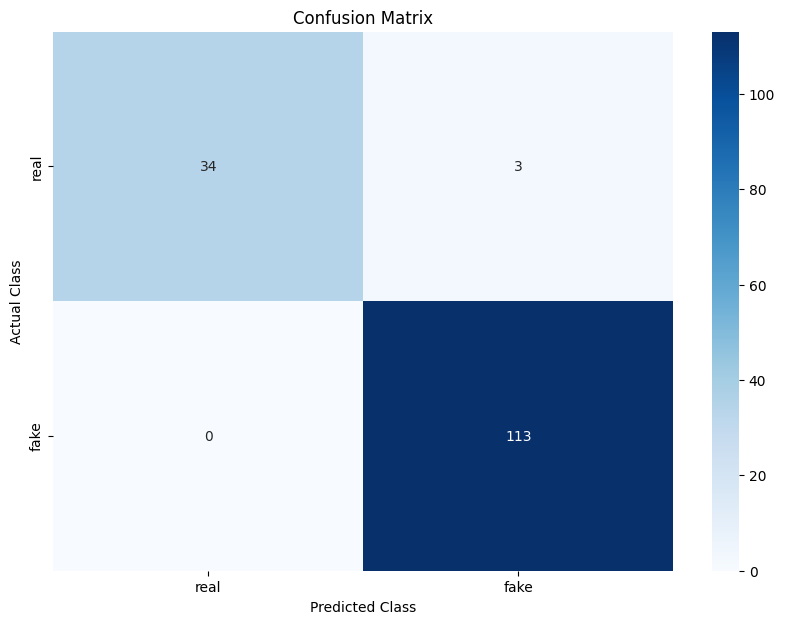

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_test_pred = cnn_model.predict(X_test)

# Convert predictions to binary labels (0 or 1)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_dict.values(), yticklabels=class_dict.values(),cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()
